Many-Body Chern Number without Integration

Koji Kudo, Haruki Watanabe, Toshikaze Kariyado, and Yasuhiro Hatsugai

Phys. Rev. Lett. 122, 146601 – Published 9 April 2019

https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.122.146601

In [201]:
using QuantumOptics
using NBInclude
@nbinclude("Lattice_Basis_Neighbors_Hops.ipynb"; regex=r"#.*executeme")
@nbinclude("QOJulia_utils.ipynb")
@nbinclude("Chern_utils.ipynb")

calc_all_states_H_mb (generic function with 1 method)

# Parameters

In [191]:
param_dict=Dict{}()

LL = [5, 5]
N = LL[1]*LL[2]
vv_lattice = [ [1., 0], [0, 1.] ]
b1=[0, 0]
vv_basis = [b1]

param_dict["LL"] = LL
param_dict["vv_lattice"] = vv_lattice
param_dict["vv_basis"] = vv_basis

nb = 1
t=-1
p=1
q=5
ϕ=p/q
param_dict["gauge"] = "Landau"
param_dict["t"]=t
param_dict["ϕ"]=ϕ
θθ = [0, 0]
param_dict["θθ"]=θθ

sites, site_coord, site_number = get_sites(LL, vv_lattice, vv_basis);
param_dict["sites"] = sites
param_dict["site_coord"] = site_coord
param_dict["site_number"] = site_number;

pbc=true
param_dict["pbc"] = pbc;
neighbors = [ [1, 0, 1], [-1, 0, 1], [0, 1, 1], [0, -1, 1]  ];
neighbors_list = [ neighbors ];
param_dict["neighbors_list"] = neighbors_list;

N1 = 20
N2 = 20
dx=2*pi/N1
dy=dx
Tx=collect(range(start=0, stop=2*pi-dx, step=dx))
Ty=collect(range(start=0, stop=2*pi-dy, step=dy));

param_dict["Tx"] = Tx;
param_dict["Ty"] = Ty;

# Single Particle

In [192]:
basis = NLevelBasis(N) 
param_dict["basis"] = basis;

In [193]:
param_dict["model_H1"] = get_Hofstadter_hamiltonian
H_T = get_Hofstadter_hamiltonian(param_dict);

H1 = get_sp_op(basis, H_T);

EE, UU = eigenstates(dense(H1));

### Single Particle Chern

In [194]:
param_dict["param_1"] = "Tx"
param_dict["param_2"] = "Ty"
EEA, UUA = calc_all_states_H1(param_dict);

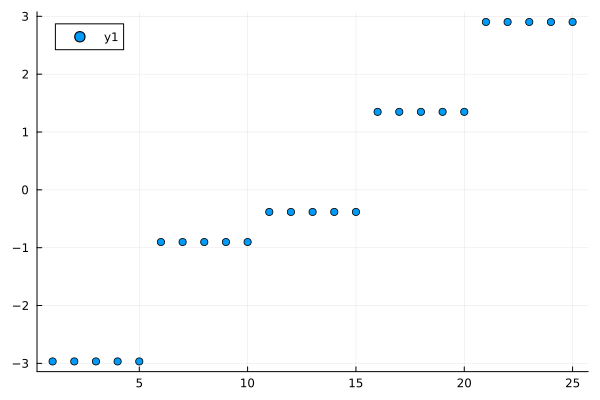

In [195]:
using Plots
scatter(real(EEA[1,1,:]))

In [196]:
bands = [[1,3],[4,6],[7,9]]
bands = [[1,5],[6,10],[11,15],[16,20],[21,25]]
calc_chern_bands(UUA, bands)

5-element Vector{Any}:
  0.9999999999999998 + 2.9099219531355976e-16im
  1.0000000000000002 + 3.0016888307938423e-16im
 -3.9999999999999996 - 5.454154317040941e-16im
  1.0000000000000002 + 2.328159222996824e-16im
  1.0000000000000004 + 1.1001100695711621e-16im

## Projected Single Particle

In [197]:
sub_states = get_subset_states(H1, 1:5);
subspace_proj, P, Pt = get_projector_op(basis, sub_states);
H1_proj = get_subspace_op(H1, P, Pt)
#param_dict["subspace_proj"] = subspace_proj
param_dict["projection"] = subspace_proj, P, Pt;

### Projected Single Particle Chern

In [198]:
param_dict["sub_range"] = 1:5
EEA, UUA = calc_all_states_H1(param_dict);

In [200]:
bands = [[1,5]]
calc_chern_bands(UUA, bands)

1-element Vector{Any}:
 0.9999999999999998 + 2.9099219531355976e-16im

# Many Body

In [202]:
delete!(param_dict, "sub_range");

In [203]:
PN = 2
param_dict["PN"] = PN
basis_mb = get_basis_mb(param_dict)

ManyBody(onebodybasis=NLevel(N=25), states:325)

In [204]:
param_dict["basis_mb"]

ManyBody(onebodybasis=NLevel(N=25), states:325)

In [205]:
param_dict["dimH_mb"] = length(basis_mb)

325

## Non-Interacting Many Body

In [206]:
basis_mb.shape[1]

325

In [207]:
H1_mb = get_mb_op(basis_mb, H1);

In [208]:
EEA, UUA = calc_all_states_H_mb(param_dict);

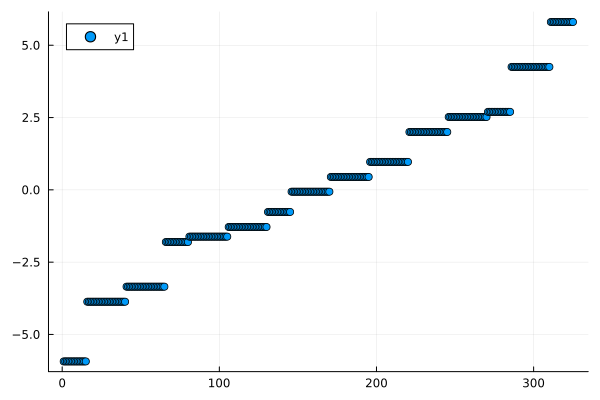

In [209]:
scatter(real(EEA[1,1,:]))

### Non-Interacting Many Body Chern

In [136]:
bands = [[1,6], [7,15], [16,24], [25,30], [31,39], [40,45]]
calc_chern_bands(UUA, bands)

6-element Vector{Any}:
                   4.0 - 3.1250401373865176e-16im
   -3.0000000000000004 + 7.585497596397408e-16im
   -0.9999999999999999 - 8.362761203693972e-17im
 2.208718528794109e-16 + 3.1166556617457667e-16im
   -3.0000000000000004 - 5.304278528981119e-16im
    3.9999999999999996 - 2.9458891225375714e-16im

## Interacting Many Body

### Interacting Many Body Chern

# Projected Many Body

In [276]:
param_dict["sub_range"] = 1:17;

In [277]:
param_dict["θθ"] = [0, 0];

In [278]:
H_T = get_Hofstadter_hamiltonian(param_dict);
H1 = get_sp_op(basis, H_T);
sub_states = get_subset_states(H1, param_dict["sub_range"])

subspace_proj, P, Pt = get_projector_op(basis, sub_states);
param_dict["projection"] = subspace_proj, P, Pt;

In [279]:
PN = 1
param_dict["PN"] = PN
basis_mb_chern = get_basis_mb(param_dict);
param_dict["basis_mb"] = basis_mb_chern

ManyBody(onebodybasis=Subspace(superbasis=NLevel(N=25), states:17), states:17)

In [280]:
param_dict["dimH_mb"] = length(basis_mb_chern)

17

## Projected Non-Interacting Many Body

In [281]:
EEA, UUA = calc_all_states_H_mb(param_dict);

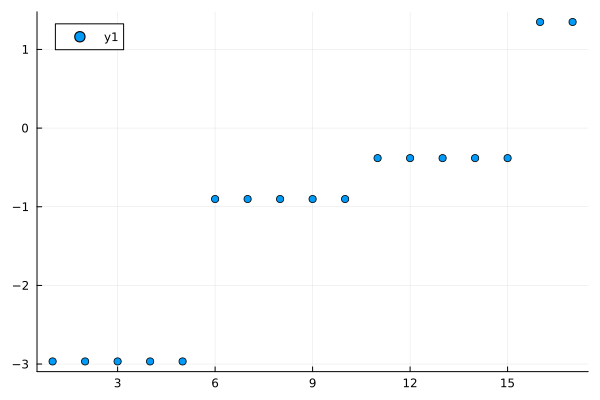

In [282]:
scatter(EEA[1,1,:])#, ylimits=(-6,-4))

### Projected Many Body Chern

In [283]:
#bands = [[1,6], [7,15], [16,21]]
#bands = [[1,3], [4,6]]
#bands = [[1,3]]
bands = [[1,5],[6,10],[11,15]]
calc_chern_bands(UUA, bands)

3-element Vector{Any}:
 1.0000000000000004 + 6.711959124541936e-16im
 1.0000000000000002 + 4.4294265901893034e-16im
 -4.000000000000001 + 2.804863940227405e-16im